In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,GRU,BatchNormalization,Activation
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from numpy import hstack
from keras.optimizers import Adam,Adadelta,RMSprop
sns.set(rc={'figure.figsize':(12.7,9.27)})
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping





Using TensorFlow backend.


In [2]:
def trim_scale_df(df):
    df = df[['Date','Close']]
    scaler = MinMaxScaler()
    df['Close_Scaled'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))
    df['Close_Scaled'] = df['Close_Scaled'].fillna(df['Close_Scaled'].mean())
    return df

In [187]:
def split_train_test(df):
    train_df = df[df.Date < '2019-01-01']
    test_df = df[df.Date >= '2019-01-01']
    y_train = train_df['Close_Scaled'] #will use length=1 in TimeSeriesGenerator to specify the lag ClosedScaled value as a target
    y_test = test_df['Close_Scaled']
    return train_df , test_df

def get_features_and_labels(df):
    return df.drop(['Close','Date'],axis=1), df['Close_Scaled']

In [188]:
sp_500df = pd.read_csv('data/sp500.csv')
dji_df = pd.read_csv('data/DJI.csv')
eem_df = pd.read_csv('data/EEM.csv')
yield_10years_df = pd.read_csv('data/United States_10_Year_Bond_Yield_Historical_Data.csv')
cboe_interest_rates_df = pd.read_csv('data/CBOE Interest Rate.csv')
btc_df = pd.read_csv('data/BTC-USD.csv')


sp_500df['Date'] = pd.to_datetime(sp_500df['Date'])
dji_df['Date'] = pd.to_datetime(dji_df['Date'])
eem_df['Date'] = pd.to_datetime(eem_df['Date'])
yield_10years_df['Date'] = pd.to_datetime(yield_10years_df['Date'])
cboe_interest_rates_df['Date'] = pd.to_datetime(cboe_interest_rates_df['Date'])
btc_df['Date'] = pd.to_datetime(btc_df['Date'])



#Make all the dataframes with same length to cboe interest for example
sp_500df = pd.merge(sp_500df,cboe_interest_rates_df['Date'],on='Date')
yield_10years_df = pd.merge(yield_10years_df,cboe_interest_rates_df['Date'],on='Date')
dji_df = pd.merge(dji_df,cboe_interest_rates_df['Date'],on='Date')
eem_df = pd.merge(eem_df,cboe_interest_rates_df['Date'],on='Date')
btc_df = pd.merge(btc_df,cboe_interest_rates_df['Date'],on='Date')

#sorting by date
sp_500df = sp_500df.sort_values(by=['Date'])
dji_df = dji_df.sort_values(by=['Date'])
eem_df = eem_df.sort_values(by=['Date'])
cboe_interest_rates_df = cboe_interest_rates_df.sort_values(by=['Date'])
yield_10years_df = yield_10years_df.sort_values(by=['Date'])
btc_df = btc_df.sort_values(by=['Date'])


#log btc price
btc_df['Close'] = np.log(btc_df['Close'])

In [189]:
sp_500_scaled_df = trim_scale_df(sp_500df)
dji_scaled_df = trim_scale_df(dji_df)
yield_10years_scaled_df = trim_scale_df(yield_10years_df)
cboe_interest_rates_scaled_df = trim_scale_df(cboe_interest_rates_df)
eem_scaled_df = trim_scale_df(eem_df)
btc_scaled_df = trim_scale_df(btc_df)



/Users/yehiaelshater/anaconda/envs/mypython3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/yehiaelshater/anaconda/envs/mypython3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/yehiaelshater/anaconda/envs/mypython3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,sp500,dji,10years_yield,cboe_interest,btc,eem
sp500,1.000000,0.995125,-0.311121,0.648775,0.928023,0.589911
dji,0.995125,1.000000,-0.274353,0.680864,0.939710,0.610634
10years_yield,-0.311121,-0.274353,1.000000,-0.010720,-0.334256,0.137336
cboe_interest,0.648775,0.680864,-0.010720,1.000000,0.645684,0.585061
btc,0.928023,0.939710,-0.334256,0.645684,1.000000,0.651262
eem,0.589911,0.610634,0.137336,0.585061,0.651262,1.000000


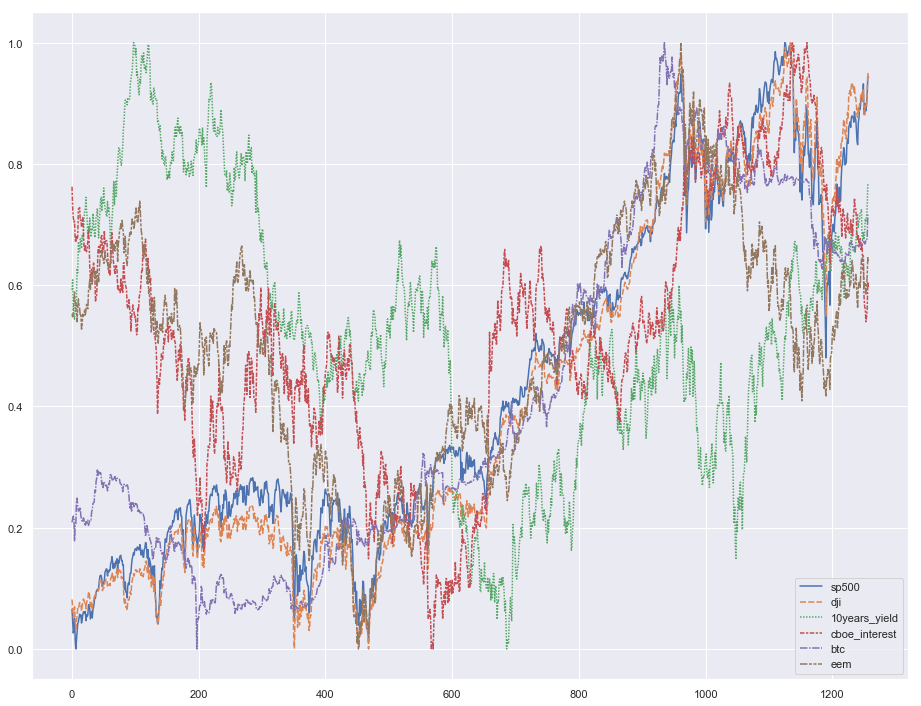

In [190]:
#sp_500_trimmed_df
#sns.lineplot(x='Date',y='Close_Scaled',data=sp_500_trimmed_df)
sns.set(rc={'figure.figsize':(15.7,12.27)})
chart_df = pd.DataFrame()
chart_df['sp500'] = sp_500_scaled_df['Close_Scaled']
chart_df['dji'] = dji_scaled_df['Close_Scaled']
chart_df['10years_yield'] = yield_10years_scaled_df['Close_Scaled']
chart_df['cboe_interest'] = cboe_interest_rates_scaled_df['Close_Scaled']


chart_df['btc'] = btc_scaled_df['Close_Scaled']
chart_df['eem'] = eem_scaled_df['Close_Scaled']

sns.lineplot(data=chart_df)

chart_df.corr()



In [191]:
# horizontally stack columns example
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95, 105])
print(in_seq1.shape)
in_seq1 = in_seq1.reshape(-1, 1)
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
print(in_seq1.shape)


stacked_seq = hstack((in_seq1, in_seq2))
stacked_seq

(10,)
(10, 1)


array([[ 10,  15],
       [ 20,  25],
       [ 30,  35],
       [ 40,  45],
       [ 50,  55],
       [ 60,  65],
       [ 70,  75],
       [ 80,  85],
       [ 90,  95],
       [100, 105]])

In [192]:
def trim_dfs_list_to_min_length(list_of_dfs):
    new_list = []
    min_length = np.min([len(df) for df in list_of_dfs])
    for df in list_of_dfs:
        new_list.append(df[:min_length])
    return new_list

In [193]:
def plot_history(history,offset=0):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  hist = hist[offset:]

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.ylim([hist['mean_absolute_error'].min(),hist['mean_absolute_error'].max()])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.ylim([hist['mean_squared_error'].min(),hist['mean_squared_error'].max()])
  plt.legend()
  plt.show()

In [194]:
n_length = 15 #number of the past days to predict the future value
BATCH_SIZE = n_length*15

train_sp_df,test_sp_df = split_train_test(sp_500_scaled_df)
train_dji_df,test_dji_df = split_train_test(dji_scaled_df)
train_yield10_years_df,test_yield10_years_df = split_train_test(yield_10years_scaled_df)
train_cboe_interest_rates_df,test_cboe_interest_rates_df = split_train_test(cboe_interest_rates_scaled_df)
train_eem_df,test_eem_df = split_train_test(eem_scaled_df)
train_btc_df,test_btc_df = split_train_test(btc_scaled_df)


#make all the dataframes with same length
train_dfs_list = [train_sp_df,train_dji_df,train_yield10_years_df,train_cboe_interest_rates_df,train_eem_df]
train_dfs_list = trim_dfs_list_to_min_length(train_dfs_list)
train_dfs_list_reshaped = [df['Close_Scaled'].values.reshape(-1,1) for df in train_dfs_list]
train_features_dataset= hstack(train_dfs_list_reshaped)

#train_targets = train_btc_df['Close_Scaled'].values
#train_targets = train_targets[:len(train_dfs_list[0])]

train_targets = train_sp_df['Close_Scaled'].values
train_targets = train_targets[:len(train_dfs_list[0])]


test_dfs_list = [test_sp_df,test_dji_df,test_yield10_years_df,test_cboe_interest_rates_df,test_eem_df]
test_dfs_list = trim_dfs_list_to_min_length(test_dfs_list)
test_dfs_list_reshaped = [df['Close_Scaled'].values.reshape(-1,1) for df in test_dfs_list]
test_features_dataset= hstack(test_dfs_list_reshaped)

#test_targets = test_btc_df['Close_Scaled'].values
#test_targets = train_targets[:len(test_dfs_list[0])]

test_targets = test_sp_df['Close_Scaled'].values
test_targets = test_targets[:len(test_dfs_list[0])]




n_features = train_features_dataset.shape[1]
generator = TimeseriesGenerator(data=train_features_dataset,targets=train_targets,batch_size=BATCH_SIZE,length=n_length)
len(generator)
x,y = generator[0]
#assert x[0] == x_train_sp_features[0]
#assert y[0] == x_train_sp_features[1] #lagged by length=1
print(x.shape)
print(y.shape)

regressor = Sequential()

print(n_length, n_features)
regressor.add(GRU(256, activation='relu', input_shape=(n_length, n_features)))
regressor.add(Dropout(0.05))
regressor.add(Dense(units=1))

regressor.add(Activation(activation='linear'))

regressor.compile(optimizer=RMSprop(lr=0.001), loss='mse',metrics=['mse','mae'])

early_stop = EarlyStopping(monitor='mean_squared_error', patience=200)



#regressor.fit(x_train_sp_features, x_train_sp_labels, epochs = 100, batch_size = 32)
history = regressor.fit_generator(generator, epochs=500, verbose=0,callbacks=[early_stop])


'''
More complicated model
model = Sequential()  
model.add(LSTM(5, 300, return_sequences=True))  
model.add(LSTM(300, 500, return_sequences=True))  
model.add(Dropout(0.2))  
model.add(LSTM(500, 200, return_sequences=False))  
model.add(Dropout(0.2))  
model.add(Dense(200, 3))  
model.add(Activation("linear"))  
'''

(225, 15, 5)
(225,)
15 5


'\nMore complicated model\nmodel = Sequential()  \nmodel.add(LSTM(5, 300, return_sequences=True))  \nmodel.add(LSTM(300, 500, return_sequences=True))  \nmodel.add(Dropout(0.2))  \nmodel.add(LSTM(500, 200, return_sequences=False))  \nmodel.add(Dropout(0.2))  \nmodel.add(Dense(200, 3))  \nmodel.add(Activation("linear"))  \n'

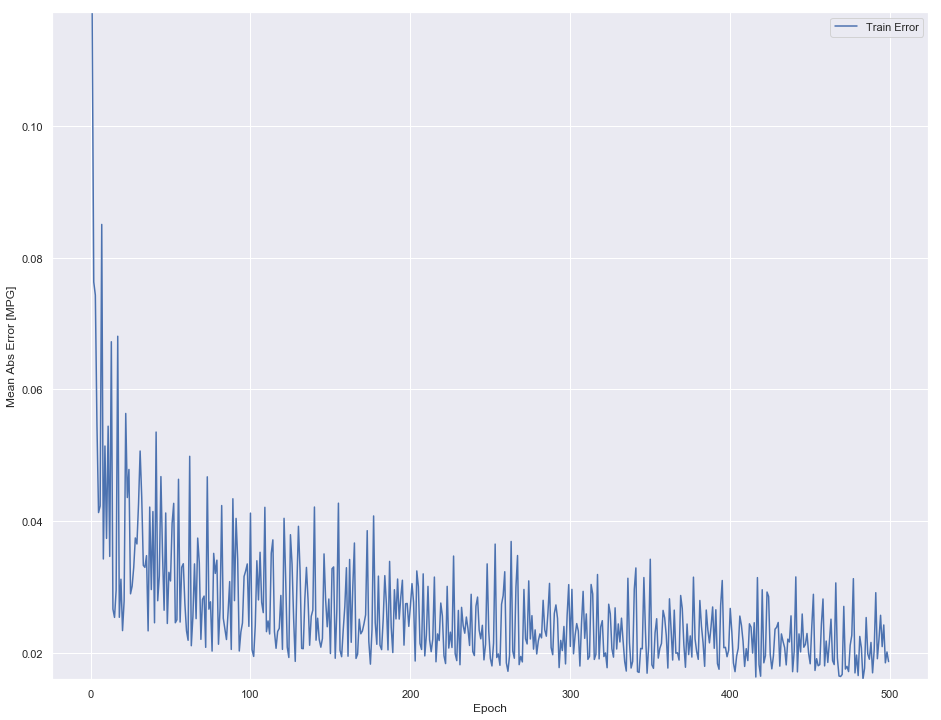

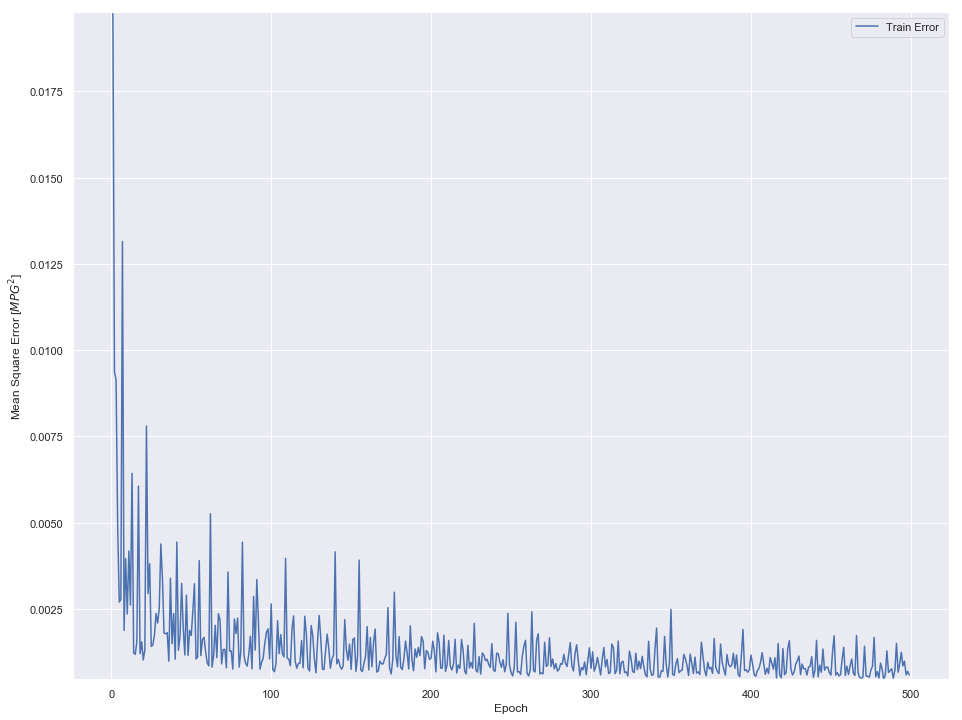

In [195]:
plot_history(history,1)


In [199]:
test_generator = TimeseriesGenerator(data=test_features_dataset,targets=test_targets,batch_size=BATCH_SIZE,length=n_length)
pd.DataFrame(regressor.predict_generator(test_generator))

score_train = regressor.evaluate_generator(generator)
score_test  = regressor.evaluate_generator(test_generator)
print(score_train,score_test)

#last_x,last_y = generator[len(generator)-1]





[0.0003256910411798296, 0.0003256910411798296, 0.01282734986934953] [0.0007570094312541187, 0.0007570094312541187, 0.023795129731297493]


48


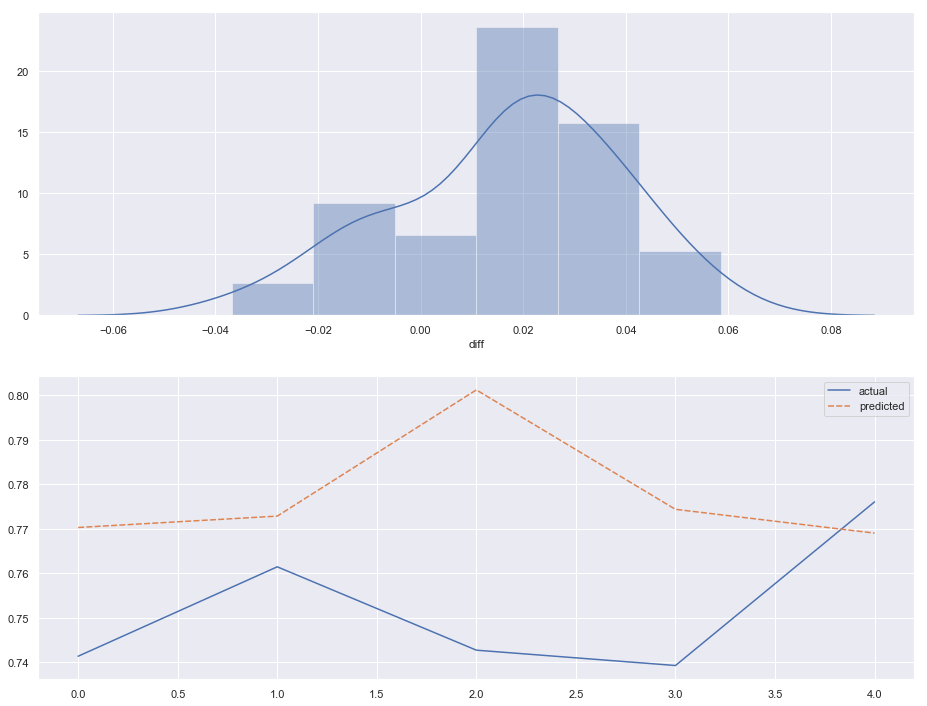

In [206]:
print(len(pd.DataFrame(regressor.predict_generator(test_generator))))
df1 = pd.DataFrame(regressor.predict_generator(test_generator),columns=['predicted'])
df2 = pd.DataFrame(test_targets,columns=['actual']).shift(-1*n_length ).dropna()
concat_results = pd.concat([df1,df2],axis=1)
concat_results['diff'] = concat_results['predicted'] - concat_results['actual'] 

fig, (ax1, ax2) = plt.subplots(nrows=2)
sns.distplot(concat_results['diff'],ax=ax1)
s2 = sns.lineplot(data=concat_results[['actual','predicted']][:5],ax=ax2)






In [201]:
concat_results[-30:]

,predicted,actual,diff
18,0.891659,0.869020,0.022638
19,0.898440,0.860214,0.038227
20,0.894527,0.876168,0.018359
21,0.902516,0.879253,0.023263
22,0.909082,0.877271,0.031811
23,0.899817,0.875908,0.023909
24,0.906977,0.868832,0.038144
25,0.903309,0.886051,0.017258
26,0.922081,0.876294,0.045787
27,0.896444,0.873460,0.022984


In [129]:
def predict_multi_steps(regressor_model,last_training_example,window_size=3):
    predict_vec = np.array([])
    for w in range(window_size):
        print(last_training_example.shape)
        print()
        last_training_example = last_training_example.reshape(1,last_training_example.shape[0],last_training_example.shape[1])
        if len(predict_vec) ==0:
            predict_vec = last_training_example
        next_predict_value = regressor_model.predict(last_training_example)
        predict_vec = np.append(predict_vec,next_predict_value[0])
        print(predict_vec)
        print(len(predict_vec))
        last_training_example = np.array([predict_vec[-1*n_length :]]).reshape(n_length,-1)
        print('last_training_example.shape')
        print(last_training_example.shape)
    predict_vec = predict_vec[n_length:] #trimming the last_training_example
    return np.array(predict_vec)
